# Определение перспективного тарифа для телеком-компании

В вашем распоряжении данные компании «Мегалайн» — федерального оператора сотовой связи.  Данные представлены за 2018 год.  Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. Цель проекта - проанализировать поведение клиентов и сделать вывод — какой тариф лучше.
По каждому клиенту у нас имеется следующие данные:
- описание тарифов «Смарт» и «Ультра»:
- ежемесячная плата;
- включенные в тариф минуты;
- включенные в тариф сообщения;
- включенный в тариф трафик передачи данных;
- стоимость трафика, минут и сообщений сверх, включенных в тариф;
- округление происходит в большую сторону для минут и Гб трафика.
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам.

Таким образом, на основе изучения статистических характеристик ежемесячных расходов абонентов необходимо осуществить выбор из двух тарифных планов, обеспечивающих максимизацию математического ожидания прибыли оператора сотовой связи.


Введенные допущения:
- стоимость тарифа списывается полностью в первый день пользования тарифом либо в первый день месяца;
- стоимость тарифа списывается полностью и не уменьшается в случае если абонент пользовался им меньше месяца;
- абоненты не пользуются другими платными услугами кроме озвученных выше;
- абоненты не находились в роуминге;
- у абонентов это единственный номер, не существует абонентов, которые используют данный номер, например, только для служебных звонков либо, либо, например, в качестве тарифа для умного устройства, требующего выход в интернет;
- абоненты не могут уйти к другому оператору или перейти на другой тарифный план кроме представленных двух.

## Изучение данных из файлов

In [1]:
import pandas as pd 
import numpy as np 
from math import ceil
from scipy import stats as st
import matplotlib.pyplot as plt

In [2]:
FORMAT='%Y-%m-%d' #формат записи даты

In [3]:
df_calls= pd.read_csv('calls.csv')
df_internet=pd.read_csv('internet.csv')
df_messages=pd.read_csv('messages.csv')
df_tariffs=pd.read_csv('tariffs.csv')
df_users=pd.read_csv('users.csv')                   

In [4]:
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [5]:
df_calls[df_calls['duration']==0]['duration'].count()

39613

In [6]:
df_internet.sample(n=10)

,Unnamed: 0,id,mb_used,session_date,user_id
118199,118199,1397_6,980.37,2018-12-31,1397
26033,26033,1089_325,72.61,2018-08-08,1089
60070,60070,1204_155,532.15,2018-07-13,1204
21633,21633,1072_356,250.93,2018-08-31,1072
1115,1115,1005_35,338.08,2018-05-21,1005
37086,37086,1129_36,759.48,2018-12-17,1129
98765,98765,1331_289,690.51,2018-08-15,1331
36653,36653,1127_3,0.00,2018-10-19,1127
99651,99651,1334_57,0.00,2018-12-30,1334
140041,140041,1470_63,304.23,2018-12-29,1470


In [7]:
df_internet[df_internet['mb_used']==0]['mb_used'].count()

19598

In [8]:
df_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [9]:
df_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [10]:
df_users.head()


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [11]:
df_users.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

In [12]:
df_tariffs['mb_per_month_included']=df_tariffs['mb_per_month_included']/1024

In [13]:
df_messages=df_messages.drop_duplicates()

In [14]:
df_calls=df_calls[df_calls['duration']!=0]

In [15]:
df_internet=df_internet[df_internet['mb_used']!=0]

In [16]:
df_calls['duration'].describe()

count    162994.000000
mean          8.397794
std           5.353022
min           0.010000
25%           4.170000
50%           7.740000
75%          11.850000
max          38.000000
Name: duration, dtype: float64

### Выводы

- В данных о звонках имеется много нулевых звонков, т.е. абоненты не дозвонились. Стоимость таких звонков равно 0, поэтому от них можно избавиться в рамках решения данной задачи.
- В данных о выходе  в интернет имеется много нулевых значений для объема данных, поэтому от них можно избавиться в рамках решения данной задачи.
- Среди данных о пользователях имеется 38 абонентов, которые перестали пользоваться тарифом. Что с этим делать, решим в ходе дальнейшей обработки данных.


**Убрал про возраст**

## Предобработка данных

Округлили все минуты ввсерх до смерживания как указано в тарифе

In [17]:
df_calls['duration']=pd.to_numeric(df_calls['duration'])
df_calls['duration']=df_calls['duration'].fillna(-2)
df_calls['duration']=df_calls['duration'].apply(ceil)
df_calls['duration']=df_calls['duration'].replace(-2,0)

Округлили все Мб ввсерх до смерживания как указано в тарифе

In [18]:
df_internet['mb_used']=pd.to_numeric(df_internet['mb_used'])
df_internet['mb_used']=df_internet['mb_used'].fillna(-2)
df_internet['mb_used']=df_internet['mb_used'].apply(ceil)
df_internet['mb_used']=df_internet['mb_used'].replace(-2,0)

Преобразования к формату даты

In [19]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'] ,format=FORMAT)
df_internet['session_date']=pd.to_datetime(df_internet['session_date'] ,format=FORMAT)
df_messages['message_date']=pd.to_datetime(df_messages['message_date'] ,format=FORMAT)
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'] ,format=FORMAT)
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'] ,format=FORMAT)

Добавление нового столбца с месяцем

In [20]:
df_calls['month']=df_calls['call_date'].dt.month
df_internet['month']=df_internet['session_date'].dt.month
df_messages['month']=df_messages['message_date'].dt.month
df_users['month_reg'] = df_users['reg_date'].dt.month # заменили дату только на месяц
df_users['month_churn'] = df_users['churn_date'].dt.month # заменили дату только на месяц

In [21]:
df_users['month_reg'] =df_users['month_reg'].fillna(-1) # заменили пропуски в месяцах регистрации абонентов
df_users['month_churn'] = df_users['month_churn'].fillna(13)# заменили пропуски в месяце прекращения пользования тарифом

In [22]:
df_calls=df_calls.pivot_table(index='user_id',columns='month', values='duration', aggfunc='sum' )

In [23]:
df_internet=df_internet.pivot_table(index='user_id',columns='month', values='mb_used', aggfunc='sum' )

In [24]:
df_messages = df_messages.drop('message_date', 1) # теперь этот столбец нам не нужен
df_messages=df_messages.pivot_table(index='user_id',columns='month', aggfunc='count' )

Создали общую таблицы со всеми нужными данными

In [25]:
df=df_users.merge(df_calls, on='user_id', how='outer').\
            merge(df_internet, on='user_id', how='outer').\
            merge(df_messages, on='user_id', how='outer')

/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


Переименовали колонки, избавились от мульти-индексов

In [26]:
df.columns=['user_id',         'age',  'churn_date',        'city',
        'first_name',   'last_name',    'reg_date',      'tariff',
         'month_reg', 'month_churn',
            '1_cls','2_cls','3_cls', '4_cls','5_cls','6_cls',
            '7_cls','8_cls','9_cls', '10_cls','11_cls','12_cls',
            '1_int','2_int','3_int',  '4_int','5_int',  '6_int',  
            '7_int','8_int','9_int',  '10_int','11_int','12_int',
            '1_msg','2_msg','3_msg',  '4_msg', '5_msg','6_msg', 
            '7_msg','8_msg','9_msg',  '10_msg','11_msg','12_msg']

- Меняем тип всех столбцов с временем разговора на числовой
- заменяем все пропуски на -2 чтобы преобразовать вверх все минуты
- Преобразовываем вверх все минуты
- Меняем -2 снова на 0.

In [27]:
temp_list=['1_cls', '2_cls', '3_cls',  '4_cls',  '5_cls', '6_cls',  '7_cls','8_cls',  '9_cls',  '10_cls',  '11_cls', '12_cls']
for i in temp_list:
    df[i]=pd.to_numeric(df[i])
    df[i]=df[i].fillna(-2)
    df[i]=df[i].apply(ceil)
    df[i]=df[i].replace(-2,0)
    

- Аналогично как для минут, но еще преобразуем в Гб

In [28]:
temp_list=['1_int','2_int','3_int','4_int','5_int','6_int','7_int','8_int','9_int','10_int','11_int','12_int']
for i in temp_list:
    df[i]=pd.to_numeric(df[i])
    df[i]=df[i].fillna(-2)
    df[i]=(df[i]/1000).apply(ceil)
    df[i]=df[i].replace(-2,0)

In [29]:
temp_list=['1_msg','2_msg','3_msg','4_msg', '5_msg','6_msg','7_msg','8_msg','9_msg',   '10_msg',   '11_msg',   '12_msg']
for i in temp_list:
    df[i]=df[i].fillna(-2)
    df[i]=(df[i]).apply(int)
    df[i]=df[i].replace(-2,0)

### Выводы

- Удалили дубликаты в сообщениях. 
- Привели Мб к Гб в таблице с описанием тарифа.
- Удалили нулевые звонки и нулевой трафик передачи данных. Так как они, обычно, не тарифицируются.
- Перевели столбец с датами в исходных таблицах к типам Дата-время.
- Добавили столбец с месяцев в каждую исходную таблицу для последующего объединения.
- Заменили пропуск в месяце регистрации абонента на -1, а в месяце прекращения пользования тарифом на 13, чтобы удобно было сравнивать.
- Удалили из таблицы с сообщениями столбец с датой отправки сообщения чтобы не загромождать общую таблицу.
- Получили сводные таблицы по месяцам с информацией об общем расходе за месяц минут, сообщений и интернет трафика.
- Объединили все DataSets в один - получился очень большой, но как-то справимся
- Поменяли название столбцов и избавились от мультииндексов.
- Округлили минуты за месяц до целых минут, а трафик до целых Гб.
- Привели минуты, Гб и сообщения к целочисленному виду.
- Заменили пропуски в сообщениях, звонках и передачи данных за месяц на 0. Зачастую это связано с тем что абонент еще не пользовался тарифом.

- Предыдущий ревьюр говорил что много комментариев к коду плохо, наверное, надо мне найти золовую середину)
- добавил округление для минут вверх до объединения
- ячейка № 25,    df[i]=(df[i]/1000).apply(ceil)

## Расчёты и добавление результатов в таблицу

In [30]:
#создание столбцов под стоимость за месяц
temp_list_price=['1_price','2_price','3_price','4_price', '5_price','6_price',
           '7_price','8_price','9_price',   '10_price',   '11_price',   '12_price']
for i in temp_list_price:
    df[i]=''


In [31]:
# списки для хранения названия столбцов с минутами, интрнет трафиком, сообщениямми и оплатой за месяц
temp_list_cls=['1_cls', '2_cls', '3_cls',  '4_cls',  '5_cls', '6_cls',  '7_cls','8_cls',  '9_cls',  '10_cls',  '11_cls', '12_cls']
temp_list_int=['1_int','2_int','3_int','4_int','5_int','6_int','7_int','8_int','9_int','10_int','11_int','12_int']
temp_list_msg=['1_msg','2_msg','3_msg','4_msg', '5_msg','6_msg','7_msg','8_msg','9_msg',   '10_msg',   '11_msg',   '12_msg']
temp_list_price=['1_price','2_price','3_price','4_price', '5_price','6_price',
           '7_price','8_price','9_price',   '10_price',   '11_price',   '12_price']

In [32]:
for i in range(len(df)): #счетчик для строк 
    for count in range(12): # счетчик для месяцев
        add_cls=0 #переменная для стоимости дополнительных минут сверх тарифа
        add_int=0 #переменная для стоимости дополнительного интернет
        add_msg=0 #переменная для стоимости дополнительных сообщений
        price=0 # переменная для хранения базовой стоимости по тарифу
        if df.loc[i, 'tariff']=='ultra':
            j=1 #номер строки в df_tariffs
            
            #Расчет стоимости дополнительных минут свехрх тарифа
            if df_tariffs.loc[j, 'minutes_included']<df.loc[i, temp_list_cls[count]]:
                add_cls=(df.loc[i, temp_list_cls[count]]-df_tariffs.loc[j, 'minutes_included'])*df_tariffs.loc[j, 'rub_per_minute']
            #Расчет стоимости дополнительного интернета сверх тарифа
            if df_tariffs.loc[j, 'mb_per_month_included']<df.loc[i, temp_list_int[count]]:
                add_int=(df.loc[i, temp_list_int[count]]-df_tariffs.loc[j, 'mb_per_month_included'])*df_tariffs.loc[j, 'rub_per_gb']    
            #Расчет стоимости дополнительных сообщений
            if df_tariffs.loc[j, 'messages_included']<df.loc[i, temp_list_msg[count]]:
                add_msg=(df.loc[i, temp_list_msg[count]]-df_tariffs.loc[j, 'messages_included'])*df_tariffs.loc[j, 'rub_per_message']
            #Базовая стоимость по тарифу
            price=df_tariffs.loc[j, 'rub_monthly_fee']              
        elif df.loc[i, 'tariff']=='smart':
            j=0 #номер строки в DataSet df_tariffs
            if df_tariffs.loc[j, 'minutes_included']<df.loc[i, temp_list_cls[count]]:
                add_cls=(df.loc[i, temp_list_cls[count]]-df_tariffs.loc[j, 'minutes_included'])*df_tariffs.loc[j, 'rub_per_minute']
            
            if df_tariffs.loc[j, 'mb_per_month_included']<df.loc[i, temp_list_int[count]]:
                add_int=(df.loc[i, temp_list_int[count]]-df_tariffs.loc[j, 'mb_per_month_included'])*df_tariffs.loc[j, 'rub_per_gb']    
            
            if df_tariffs.loc[j, 'messages_included']<df.loc[i, temp_list_msg[count]]:
                add_msg=(df.loc[i, temp_list_msg[count]]-df_tariffs.loc[j, 'messages_included'])*df_tariffs.loc[j, 'rub_per_message']
            price=df_tariffs.loc[j, 'rub_monthly_fee']    
        df.loc[i, temp_list_price[count]]=price+add_cls+add_int+add_msg

In [33]:
# заменяем на NaN все ячейки дне абонеты еще не пользовались или уже не пользовались тарифом       
for i in range(len(df)):#строки
    for count in range(12):# месеца
        if (count+1<df_users.loc[i, 'month_reg']) or (count+1>df_users.loc[i, 'month_churn']):
            df.loc[i, temp_list_price[count]]=np.nan
            df.loc[i, temp_list_cls[count]]=np.nan
            df.loc[i, temp_list_int[count]]=np.nan
            df.loc[i, temp_list_msg[count]]=np.nan
# +1 - месяцы начинаются с первого, а элементы в списке с нулевого

### Выводы

- Добавили пустые столбцы под стоимость услуг связи за месяц
- Рассчитали стоимость услуг связи по всем абонентам и добавили в соответствующие столбцы.
- Земенили месяцы в которые абоненту уже или еще не обслуживались на NaN для расчета статистических характеристик для стоимости, звонков, минут  и сообщений.

## Исследовательский анализ данных


### Расчет услуг по тарифу "Смарт"

Text(0.5, 0, 'Количество минут')

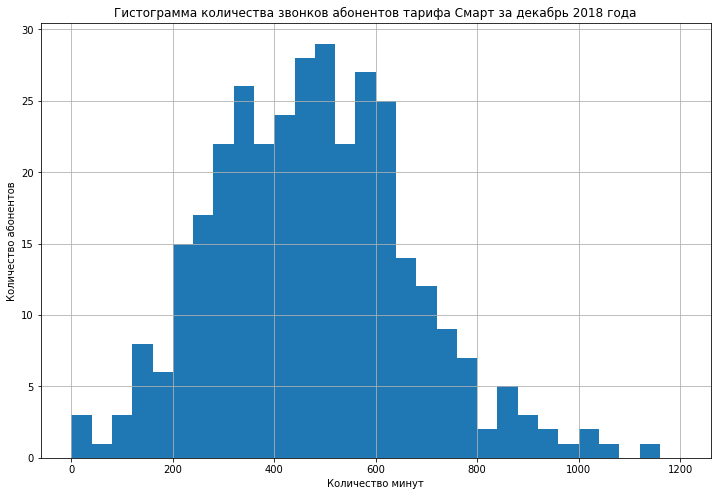

In [34]:
ax=df[df['tariff']=='smart']['12_cls'].plot(kind='hist',range=(0,1200), bins=30, figsize=(12,8), grid=True,  title='Гистограмма количества звонков абонентов тарифа Смарт за декабрь 2018 года')
ax.set_ylabel("Количество абонентов")
ax.set_xlabel("Количество минут")

Text(0.5, 0, 'Количество минут')

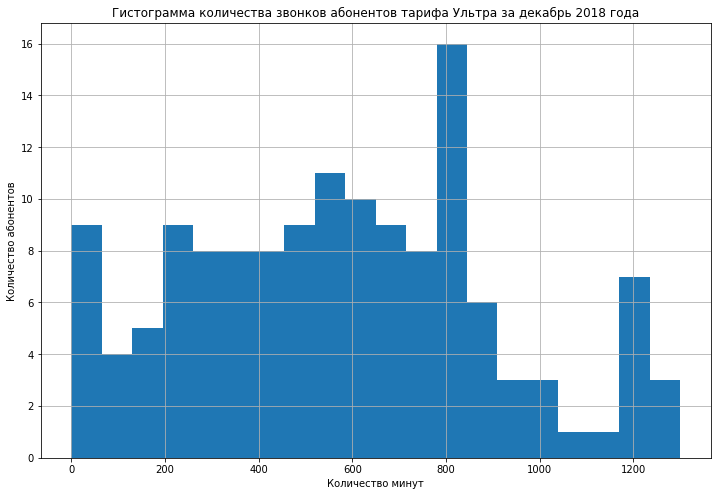

In [35]:
ax=df[df['tariff']=='ultra']['12_cls'].plot(kind='hist',range=(0,1300), bins=20, figsize=(12,8), grid=True,  title='Гистограмма количества звонков абонентов тарифа Ультра за декабрь 2018 года')
ax.set_ylabel("Количество абонентов")
ax.set_xlabel("Количество минут")

Из анализа рисунков можно сделать следующие выводы:
- Распределение минут в тарифе Смарт имеет вид похожий на нормальный;
- Распределение минут в тарифе Ультра характеризуется большим стандартным отклонением от среднего значения;
- По сравнению с тарифом Смарт у пользователей тарифа Ультра распределение смещено в область с больших значений.


Text(0.5, 0, 'Количество Гб интернет')

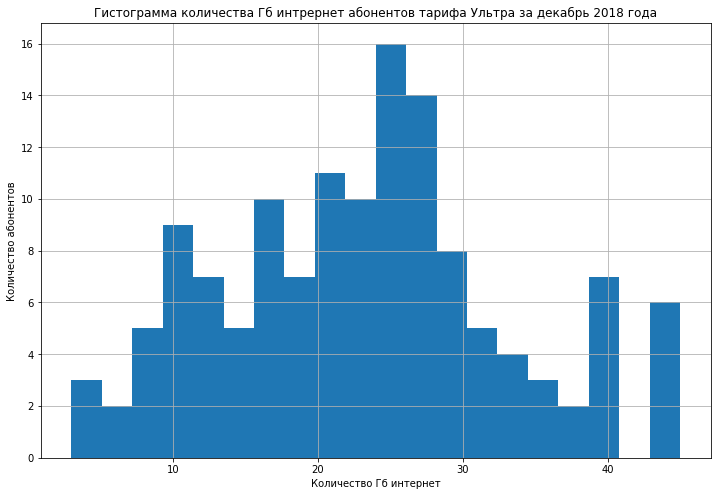

In [36]:
ax=df[df['tariff']=='ultra']['12_int'].plot(kind='hist',range=(3,45), bins=20, figsize=(12,8), grid=True,  title='Гистограмма количества Гб интрернет абонентов тарифа Ультра за декабрь 2018 года')
ax.set_ylabel("Количество абонентов")
ax.set_xlabel("Количество Гб интернет")

Из анализа рисунков можно сделать следующие выводы:
- Распределение трафика интернет за месяц  для тарифов Смарт и Ультра имеет вид похожий на нормальный;
- Распределение для тарифе Ультра характеризуется большим стандартным отклонением от среднего значения;
- По сравнению с тарифом Смарт у пользователей тарифа Ультра распределение смещено в область с больших значений.

Text(0.5, 0, 'Количество сообщений')

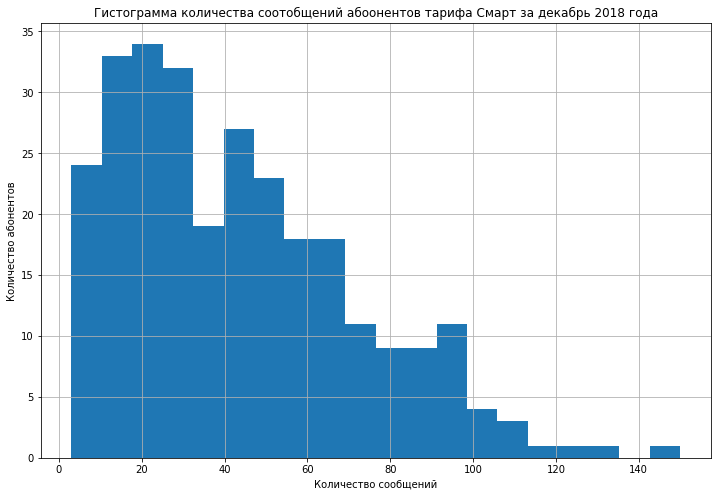

In [37]:
ax=df[df['tariff']=='smart']['12_msg'].plot(kind='hist',range=(3,150), bins=20, figsize=(12,8), grid=True,  title='Гистограмма количества соотобщений абоонентов тарифа Смарт за декабрь 2018 года')
ax.set_ylabel("Количество абонентов")
ax.set_xlabel("Количество сообщений")

Text(0.5, 0, 'Количество сообщений')

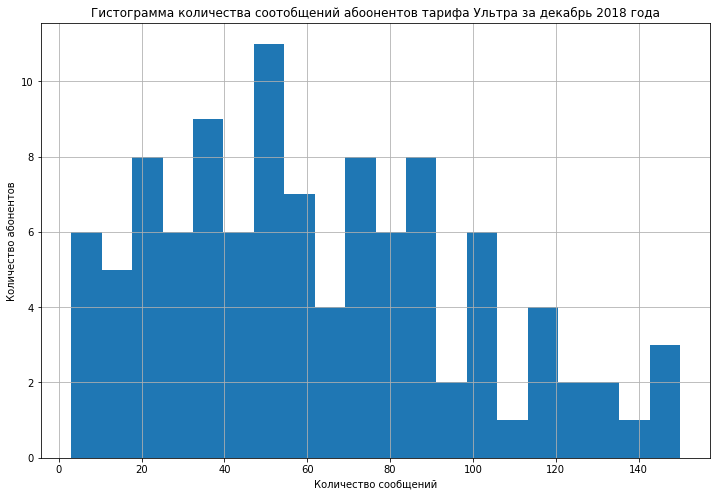

In [38]:
ax=df[df['tariff']=='ultra']['12_msg'].plot(kind='hist',range=(3,150), bins=20, figsize=(12,8), grid=True,  title='Гистограмма количества соотобщений абоонентов тарифа Ультра за декабрь 2018 года')
ax.set_ylabel("Количество абонентов")
ax.set_xlabel("Количество сообщений")

Из анализа рисунков можно сделать следующие выводы:
- Распределение сообщений за месяц  для тарифа Смарт имеет вид похожий на экспоненциальный;
- Распределение сообщений за месяц  для тарифа Ультра имеет сложный вид;
- Распределение для тарифе Ультра характеризуется большим стандартным отклонением от среднего значения;
- По сравнению с тарифом Смарт у пользователей тарифа Ультра распределение смещено в область с больших значений.

In [39]:
#создание списков для статистических характеристик по месяцам для тарифа smart
smart_cls_mean=[]
smart_cls_var=[]
smart_cls_std=[]
smart_int_mean=[]
smart_int_var=[]
smart_int_std=[]
smart_msg_mean=[]
smart_msg_var=[]
smart_msg_std=[]
#расчет среднего, дисперсии и стандартного отклонения по месяцам 
for i in range(len(temp_list_cls)):
    #расчет среднего для по месецам для звонков, интернета и сообщений
    smart_cls_mean.append(df[df['tariff']=='smart'][temp_list_cls[i]].mean())
    smart_int_mean.append(df[df['tariff']=='smart'][temp_list_int[i]].mean())
    smart_msg_mean.append(df[df['tariff']=='smart'][temp_list_msg[i]].mean())
    # это выборка, но не вся генеральная совокупность, поэтому ddof=1
    smart_cls_var.append(np.var(df[df['tariff']=='smart'][temp_list_cls[i]], ddof=1))
    smart_int_var.append(np.var(df[df['tariff']=='smart'][temp_list_int[i]], ddof=1))
    smart_msg_var.append(np.var(df[df['tariff']=='smart'][temp_list_msg[i]], ddof=1))
#расчет стандартного отклонения для по месецам для звонков, интернета и сообщений
smart_cls_std=np.sqrt(smart_cls_var)
smart_int_std=np.sqrt(smart_int_var)
smart_msg_std=np.sqrt(smart_msg_var) 

In [40]:
# создаем DataFrame со статистиками
d = {'smart_cls_mean': smart_cls_mean, 'smart_cls_var': smart_cls_var,'smart_cls_std':smart_cls_std, 
    'smart_int_mean':smart_int_mean,'smart_int_var':smart_int_var, 'smart_int_std':smart_int_std,
    'smart_msg_mean':smart_msg_mean, 'smart_msg_var':smart_msg_var,'smart_msg_std':smart_msg_std }
df_stat_smart = pd.DataFrame(data=d)

In [41]:
df_stat_smart

,smart_cls_mean,smart_cls_var,smart_cls_std,smart_int_mean,smart_int_var,smart_int_std,smart_msg_mean,smart_msg_var,smart_msg_std
0,203.852941,23787.341355,154.231454,9.029412,42.514260,6.520296,18.235294,262.367201,16.197753
1,298.689655,36412.287961,190.820041,12.103448,39.462795,6.281942,24.086207,473.097701,21.750809
2,390.051948,36823.155161,191.893604,15.571429,34.063910,5.836430,31.857143,718.492481,26.804710
3,367.133929,34778.207127,186.489161,13.928571,32.625483,5.711872,30.741071,602.139559,24.538532
4,387.361702,34820.061094,186.601343,16.347518,35.885512,5.990452,33.773050,730.990983,27.036845
5,395.640244,30742.918861,175.336587,16.286585,33.690371,5.804341,33.402439,806.806374,28.404337
6,408.353234,32250.269602,179.583601,16.253731,34.460299,5.870289,33.751244,799.887811,28.282288
7,421.468085,34793.583379,186.530382,17.161702,31.452373,5.608242,33.638298,838.257501,28.952677
8,428.611538,33535.342723,183.126576,16.819231,27.160247,5.211549,33.638462,790.617820,28.117927
9,426.136054,35392.336375,188.128510,17.251701,34.311857,5.857632,33.765306,816.111966,28.567673


In [42]:
df_stat_smart.mean()

smart_cls_mean      386.642510
smart_cls_var     33766.594834
smart_cls_std       183.430402
smart_int_mean       15.562365
smart_int_var        33.905354
smart_int_std         5.813050
smart_msg_mean       31.404336
smart_msg_var       715.059794
smart_msg_std        26.469740
dtype: float64

[Text(0, 0, 'Янв'),
 Text(0, 0, 'Фев'),
 Text(0, 0, 'Март'),
 Text(0, 0, 'Апр'),
 Text(0, 0, 'Май'),
 Text(0, 0, 'Июнь'),
 Text(0, 0, 'Июль'),
 Text(0, 0, 'Авг'),
 Text(0, 0, 'Сент'),
 Text(0, 0, 'Окт'),
 Text(0, 0, 'Ноябрь'),
 Text(0, 0, 'Дек')]

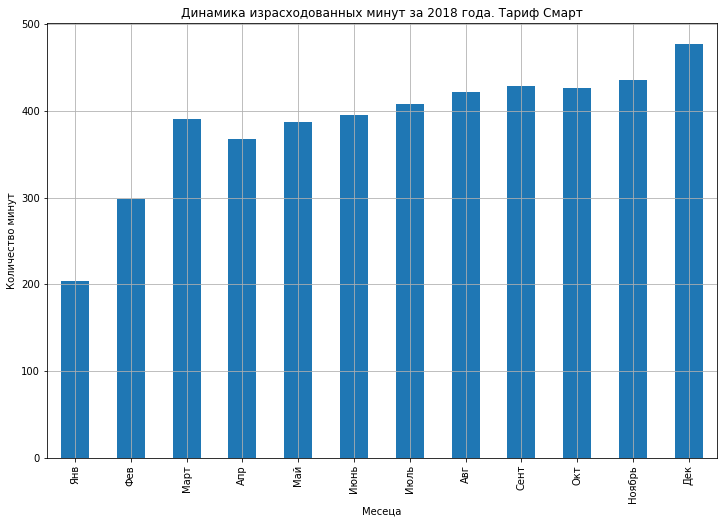

In [43]:
ax=df_stat_smart['smart_cls_mean'].plot(kind='bar', figsize=(12,8),  grid=True,  title='Динамика израсходованных минут за 2018 года. Тариф Смарт')
ax.set_ylabel("Количество минут")
ax.set_xlabel("Месеца")
stick=('Янв','Фев','Март','Апр','Май', 'Июнь','Июль','Авг','Сент','Окт','Ноябрь','Дек' )
ax.set_xticklabels(stick)

[Text(0, 0, 'Янв'),
 Text(0, 0, 'Фев'),
 Text(0, 0, 'Март'),
 Text(0, 0, 'Апр'),
 Text(0, 0, 'Май'),
 Text(0, 0, 'Июнь'),
 Text(0, 0, 'Июль'),
 Text(0, 0, 'Авг'),
 Text(0, 0, 'Сент'),
 Text(0, 0, 'Окт'),
 Text(0, 0, 'Ноябрь'),
 Text(0, 0, 'Дек')]

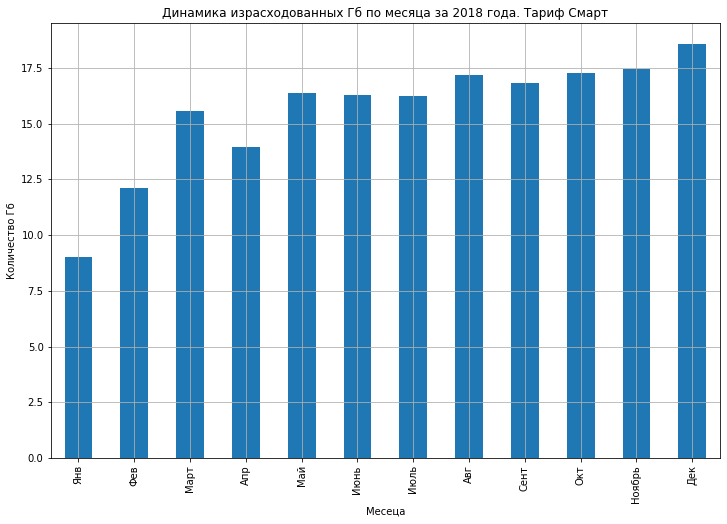

In [44]:
ax=df_stat_smart['smart_int_mean'].plot(kind='bar', figsize=(12,8),  grid=True,  title='Динамика израсходованных Гб по месяца за 2018 года. Тариф Смарт')
ax.set_ylabel("Количество Гб")
ax.set_xlabel("Месеца")
stick=('Янв','Фев','Март','Апр','Май', 'Июнь','Июль','Авг','Сент','Окт','Ноябрь','Дек' )
ax.set_xticklabels(stick)

- Пользователи тарифа Смарт в среднем используют 386 минут за месяц, 15.6 Гб интернет и 31 сообщений. 
- При этом можно отметить, что средние имеют тенденцию к увеличению и для декабря составляют уже 477 минут за месяц, 18,6 Гб интернет и 35 сообщений. 
- Это явление может быть связано с тем что абоненты подключаются зачастую не в первый день месяца и поэтому за первый месяц подключения не успевают полностью израсходовать "нормальное" для себя количество услуг связи. При этом у нас происходит увеличение количества абонентов каждый месяц. Поэтому значения за декабрь самые показательные.

### Расчет услуг по тарифу "Ультра"

In [45]:
#создание списков для статистических характеристик по месяцам для тарифа ultra
# расчет аналогичен предыдущему по тарифу Смарт
smart_cls_mean=[]
smart_cls_var=[]
smart_cls_std=[]
smart_int_mean=[]
smart_int_var=[]
smart_int_std=[]
smart_msg_mean=[]
smart_msg_var=[]
smart_msg_std=[]
for i in range(len(temp_list_cls)):
    smart_cls_mean.append(df[df['tariff']=='ultra'][temp_list_cls[i]].mean())
    smart_int_mean.append(df[df['tariff']=='ultra'][temp_list_int[i]].mean())
    smart_msg_mean.append(df[df['tariff']=='ultra'][temp_list_msg[i]].mean())
    smart_cls_var.append(np.var(df[df['tariff']=='ultra'][temp_list_cls[i]], ddof=1))
    smart_int_var.append(np.var(df[df['tariff']=='ultra'][temp_list_int[i]], ddof=1))
    smart_msg_var.append(np.var(df[df['tariff']=='ultra'][temp_list_msg[i]], ddof=1))
smart_cls_std=np.sqrt(smart_cls_var)
smart_int_std=np.sqrt(smart_int_var)
smart_msg_std=np.sqrt(smart_msg_var) 


In [46]:
#Созадаем таблицу со статистическими характеристиками по тарифу Ультра по месецам
d = {'smart_cls_mean': smart_cls_mean, 'smart_cls_var': smart_cls_var,'smart_cls_std':smart_cls_std, 
    'smart_int_mean':smart_int_mean,'smart_int_var':smart_int_var, 'smart_int_std':smart_int_std,
    'smart_msg_mean':smart_msg_mean, 'smart_msg_var':smart_msg_var,'smart_msg_std':smart_msg_std }
df_stat_ultra = pd.DataFrame(data=d)

In [47]:
df_stat_ultra

,smart_cls_mean,smart_cls_var,smart_cls_std,smart_int_mean,smart_int_var,smart_int_std,smart_msg_mean,smart_msg_var,smart_msg_std
0,428.111111,72769.361111,269.757968,13.666667,47.000000,6.855655,33.777778,940.694444,30.670742
1,297.125000,87919.679348,296.512528,12.208333,113.737319,10.664770,21.958333,716.824275,26.773574
2,489.648649,111384.900901,333.743765,18.081081,118.909910,10.904582,32.297297,1732.381381,41.621886
3,458.018182,71653.870034,267.682405,17.327273,94.816835,9.737394,31.563636,1407.287542,37.513831
4,510.328358,83870.193578,289.603511,19.880597,101.864315,10.092785,37.850746,1624.644052,40.306874
5,479.702381,91535.946500,302.549081,19.452381,86.901320,9.322088,41.726190,1986.297619,44.567899
6,545.791209,94322.278144,307.119322,21.021978,101.799512,10.089574,49.846154,2372.042735,48.703621
7,510.775701,97956.496385,312.980026,20.056075,111.355317,10.552503,48.439252,2171.739199,46.601923
8,539.443478,105716.775286,325.141162,19.730435,90.145995,9.494524,52.286957,2152.855530,46.398874
9,558.081301,106464.583500,326.289110,20.552846,96.691857,9.833202,58.430894,2697.181661,51.934398


In [48]:
df_stat_ultra.mean()

smart_cls_mean      495.581450
smart_cls_var     94925.574342
smart_cls_std       307.251407
smart_int_mean       18.705211
smart_int_var        97.736207
smart_int_std         9.834491
smart_msg_mean       43.678905
smart_msg_var      1913.985137
smart_msg_std        43.059785
dtype: float64

[Text(0, 0, 'Янв'),
 Text(0, 0, 'Фев'),
 Text(0, 0, 'Март'),
 Text(0, 0, 'Апр'),
 Text(0, 0, 'Май'),
 Text(0, 0, 'Июнь'),
 Text(0, 0, 'Июль'),
 Text(0, 0, 'Авг'),
 Text(0, 0, 'Сент'),
 Text(0, 0, 'Окт'),
 Text(0, 0, 'Ноябрь'),
 Text(0, 0, 'Дек')]

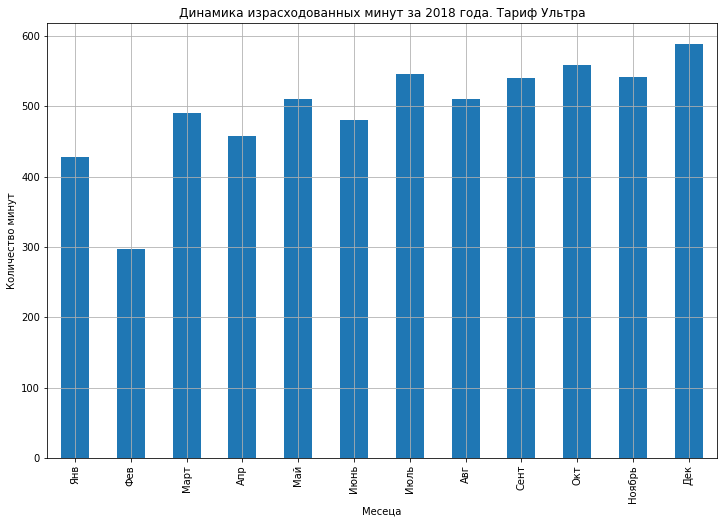

In [49]:
ax=df_stat_ultra['smart_cls_mean'].plot(kind='bar', figsize=(12,8),  grid=True,  title='Динамика израсходованных минут за 2018 года. Тариф Ультра')
ax.set_ylabel("Количество минут")
ax.set_xlabel("Месеца")
stick=('Янв','Фев','Март','Апр','Май', 'Июнь','Июль','Авг','Сент','Окт','Ноябрь','Дек' )
ax.set_xticklabels(stick)

[Text(0, 0, 'Янв'),
 Text(0, 0, 'Фев'),
 Text(0, 0, 'Март'),
 Text(0, 0, 'Апр'),
 Text(0, 0, 'Май'),
 Text(0, 0, 'Июнь'),
 Text(0, 0, 'Июль'),
 Text(0, 0, 'Авг'),
 Text(0, 0, 'Сент'),
 Text(0, 0, 'Окт'),
 Text(0, 0, 'Ноябрь'),
 Text(0, 0, 'Дек')]

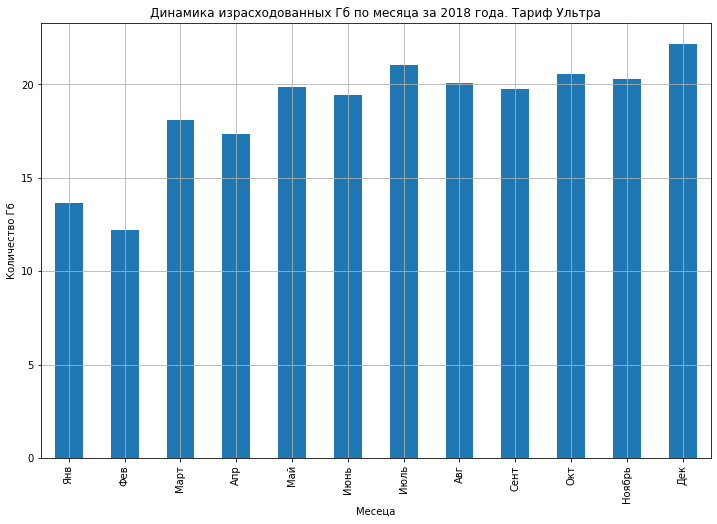

In [50]:
ax=df_stat_ultra['smart_int_mean'].plot(kind='bar', figsize=(12,8),  grid=True,  title='Динамика израсходованных Гб по месяца за 2018 года. Тариф Ультра')
ax.set_ylabel("Количество Гб")
ax.set_xlabel("Месеца")
stick=('Янв','Фев','Март','Апр','Май', 'Июнь','Июль','Авг','Сент','Окт','Ноябрь','Дек' )
ax.set_xticklabels(stick)

- Пользователи тарифа Ультра в среднем используют 468 минут за месяц, 18,7 Гб интернет и 43 сообщения. 
- При этом можно отметить, что средние имеют тенденцию к увеличению и для декабря составляют уже 556 минут за месяц, 22,2 Гб интернет и 60 сообщений. 
- Это явление может быть связано с тем что абоненты подключаются зачастую не в первый день месяца и поэтому за первый месяц подключения не успевают полностью израсходовать "нормальное" для себя количество услуг связи. При этом у нас происходит увеличение количества абонентов каждый месяц. Поэтому значения за декабрь самые показательные.

###  Сравнение количества  услуг по тарифам 

[Text(0, 0, 'Превышение по минутам'),
 Text(0, 0, 'Превышение по Гб трафика'),
 Text(0, 0, 'Превышение по сообщениям')]

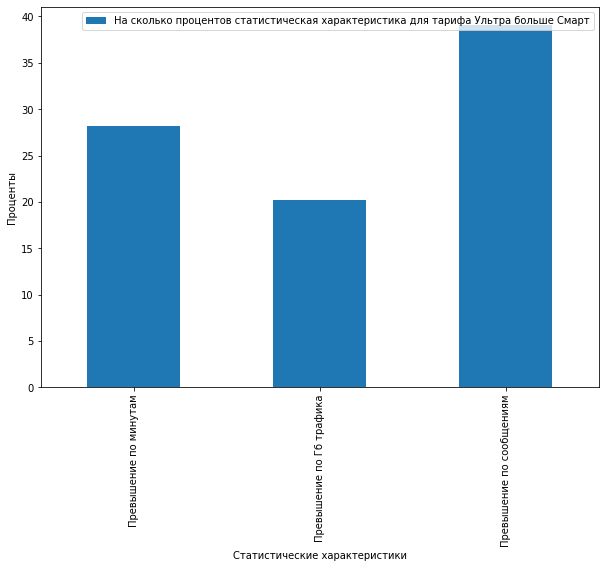

In [51]:
ax=((df_stat_ultra[['smart_cls_mean','smart_int_mean', 'smart_msg_mean']].mean()/df_stat_smart[['smart_cls_mean','smart_int_mean', 'smart_msg_mean']].mean()-1)*100).plot(kind='bar', label='На сколько процентов статистическая характеристика для тарифа Ультра больше Смарт', legend=True, figsize=(10,7))
ax.set_xlabel("Статистические характеристики")
ax.set_ylabel("Проценты")
stick=('Превышение по минутам','Превышение по Гб трафика','Превышение по сообщениям')
ax.set_xticklabels(stick)

Сравнение использования услуг для абонентов тарифов Смарт и Ультра позволяет сделать следующий вывод: 
- абоненты тарифа Ультра больше пользуются всеми услугами: звонят больше на 28%, интернет - на 20 % и сообщения на 39 %

In [52]:
((df_stat_ultra[['smart_cls_mean','smart_int_mean', 'smart_msg_mean']].mean()/df_stat_smart[['smart_cls_mean','smart_int_mean', 'smart_msg_mean']].mean()-1)*100)

smart_cls_mean    28.175624
smart_int_mean    20.195164
smart_msg_mean    39.085584
dtype: float64

###  Сравнение стоимостей  услуг связи за месяц  по тарифам 

Создал уменьшенную таблицу для цен, городов и тарифов - то что надо для проверки стат. гипотез

In [53]:
df_price=df.loc[:,['city','tariff', '1_price','2_price','3_price','4_price', '5_price','6_price',
           '7_price','8_price','9_price',   '10_price',   '11_price',   '12_price' ]].copy()

In [54]:
for i in temp_list_price:
    df_price[i]=pd.to_numeric(df_price[i])

In [55]:
df_price[df_price['tariff']=='ultra']['12_price'].mean()

2164.285714285714

In [56]:
df_price[df_price['tariff']=='smart']['12_price'].mean()

1642.3520710059172

- Средняя плата за декабрь по тарифу Смарт составляет 1593 руб., а по Ультра 2163 руб.

In [57]:
smart_price=[]
ultra_price=[]
for i in range(12):
    ultra_price.append(df[df['tariff']=='ultra'][temp_list_price[i]].mean())
    smart_price.append(df[df['tariff']=='smart'][temp_list_price[i]].mean())

Создаем новую таблицу с платой по месяцам для тарифов

In [58]:
d = {'smart_price': smart_price, 'ultra_price': ultra_price }
df_stat_price = pd.DataFrame(data=d)
df_stat_price

,smart_price,ultra_price
0,744.852941,1950.000000
1,855.189655,1987.500000
2,1213.974026,2031.081081
3,998.803571,2020.909091
4,1265.595745,2077.611940
5,1257.676829,2053.571429
6,1275.691542,2142.857143
7,1387.829787,2108.411215
8,1313.792308,2040.000000
9,1423.357143,2086.585366


- Средняя плата по месяцам по тарифам Смарт и Ультра

In [59]:
df_stat_price.mean()

smart_price    1232.912325
ultra_price    2064.687151
dtype: float64

[Text(0, 0, 'Смарт'), Text(0, 0, 'Ультра')]

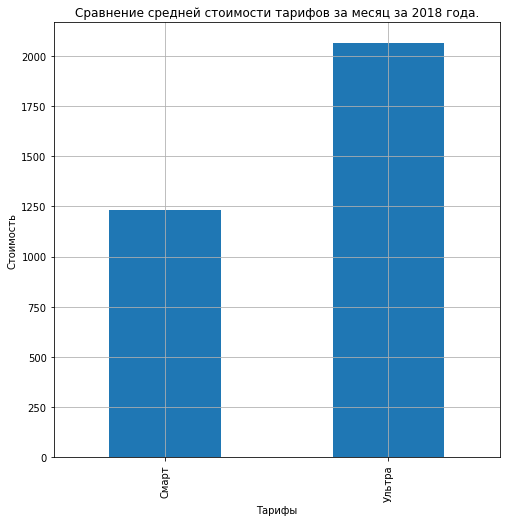

In [60]:
ax=df_stat_price.mean().plot(kind='bar', figsize=(8,8),  grid=True,  title='Сравнение средней стоимости тарифов за месяц за 2018 года.')
ax.set_ylabel("Стоимость")
ax.set_xlabel("Тарифы")
stick=('Смарт','Ультра' )
ax.set_xticklabels(stick)

- Средняя плата за 2018 по тарифу Смарт составляет 1202 руб., а по Ультра  - 2063 руб. 

[Text(0, 0, 'Янв'),
 Text(0, 0, 'Фев'),
 Text(0, 0, 'Март'),
 Text(0, 0, 'Апр'),
 Text(0, 0, 'Май'),
 Text(0, 0, 'Июнь'),
 Text(0, 0, 'Июль'),
 Text(0, 0, 'Авг'),
 Text(0, 0, 'Сент'),
 Text(0, 0, 'Окт'),
 Text(0, 0, 'Ноябрь'),
 Text(0, 0, 'Дек')]

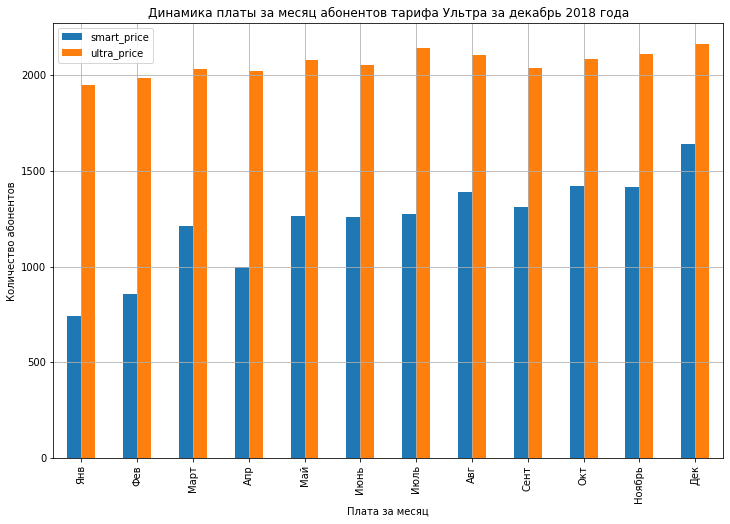

In [61]:
ax=df_stat_price.plot(kind='bar', figsize=(12,8),  grid=True,  title='Динамика платы за месяц абонентов тарифа Ультра за декабрь 2018 года')
ax.set_xlabel("Плата за месяц")
ax.set_ylabel("Количество абонентов")
stick=('Янв','Фев','Март','Апр','Май', 'Июнь','Июль','Авг','Сент','Окт','Ноябрь','Дек' )
ax.set_xticklabels(stick)

На основе рисунка можно сделать выводы:
- стоимость услуг по тарифу Смарт существенно ниже чем по Ультра;
- стоимость услуг по тарифу Смарт имеет явно выраженную тенденцию к увеличению;
- стоимость услуг по тарифу Ультра также растет, но не так значительно как по тарифу Смарт

Text(0, 0.5, 'Количество абонентов')

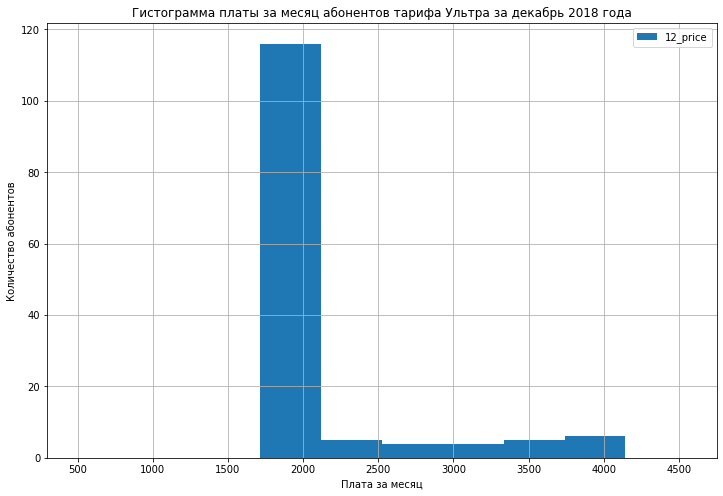

In [62]:
ax=df_price[df_price['tariff']=='ultra'][['12_price']].plot(kind='hist',range=(500,4550), bins=10, figsize=(12,8),  grid=True,  title='Гистограмма платы за месяц абонентов тарифа Ультра за декабрь 2018 года')
ax.set_xlabel("Плата за месяц")
ax.set_ylabel("Количество абонентов")

Text(0.5, 0, 'Плата за месяц абонентов')

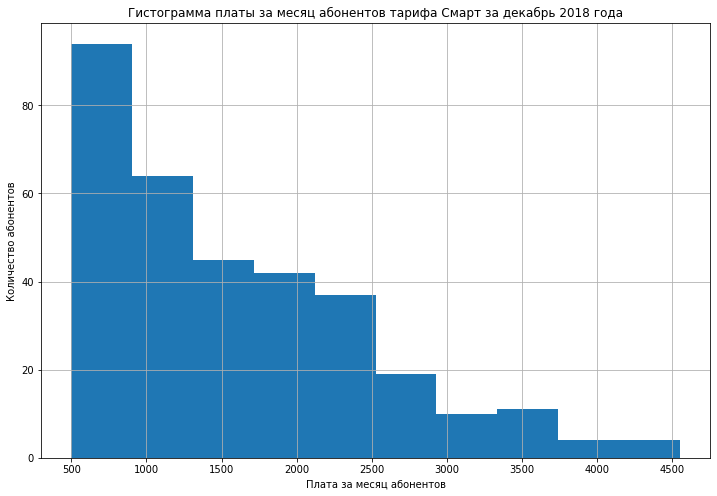

In [63]:
ax=df_price[df_price['tariff']=='smart']['12_price'].plot(kind='hist',range=(500,4550), bins=10, figsize=(12,8), grid=True,  title='Гистограмма платы за месяц абонентов тарифа Смарт за декабрь 2018 года')
ax.set_ylabel("Количество абонентов")
ax.set_xlabel("Плата за месяц абонентов")

Из представленных гистограмм стоимостей услуг за месяц за декабрь 2018 года можно сделать выводы:

- распределение стоимости за месяц по тарифу Ультра имеет явно выраженный пик в районе 1950 - стоимости тарифа;
- распределение стоимости за месяц по тарифу Смарт имеет выраженный пик в районе 550 - стоимости тарифа;
- распределение для тарифа Смарт равномерно спадает в то время как распределение для Ультра почти полностью сосредоточено в пике, а далее имеет длинный хвост в в сторону увеличения стоимости.

### Выводы

- абоненты тарифа Ультра больше пользуются всеми услугами: звонят больше на 28%, интернет - на 20 % и сообщения на 35 %

- Абоненты тарифа Смарт в среднем за месяц используют 415 мин. телефонии, 17.5 Гб передачи данных и 35 сообщений;

- Абоненты тарифа Ультра в среднем за месяц используют 532 мин. телефонии, 21 Гб передачи данных и 46 сообщений;

- средняя плата за месяц для тарифа Ультра составляет 1950 рублей, что полностью совпадает со стоимостью тарифа за месяц;

- средняя плата за месяц для тарифа Смарт составляет 662 рубля.

## Статистический анализ данных

### Гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

- H0: средняя выручка пользователей тарифов Smart и Ultra не отличается;
- H1: средняя выручка пользователей тарифов Smart и Ultra отличается.

In [64]:
results = st.ttest_ind(df_price[df_price['tariff']=='smart']['12_price'], df_price[df_price['tariff']=='ultra']['12_price'], nan_policy='omit',equal_var = False)
print('p-значение: ', results.pvalue)

p-значение:  4.695963172029635e-12


Нулевая гипотеза смело может быть отвергнута. Средняя плата за декабрь по тарифу Смарт составляет 1593 руб., а по Ультра 2163 руб. Поэтому можно утверждать, что выручка по тарифу Smart существенно ниже. Можно было бы собрать всю статистику по всем месяцам, но в этом нет необходимости. 

### Гипотеза: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

- H0: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов;

- H1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.



В отличии от предыдущей проверки, где даже на небольшой выборке можно получить однозначный ответ, для проверки этой гипотезы попытаемся увеличить выборку за счет всей статистики и объединим все данные в один список.





In [65]:
list_msk=[]
df_price_msk=df_price[df_price['city']=='Москва']
for i in temp_list_price:
    list_msk.extend(list(df_price_msk[i]))
list_nomsk=[]
df_price_nomsk=df_price[df_price['city']!='Москва']
for i in temp_list_price:
    list_nomsk.extend(list(df_price_nomsk[i]))
    

In [66]:
results = st.ttest_ind(list_msk, list_nomsk, nan_policy='omit' ,equal_var = False)
print('p-значение: ', results.pvalue)

p-значение:  0.5765226783143965


### Выводы

- Нулевая гипотеза о том , что  средняя выручка пользователей тарифов «Ультра» и «Смарт» не различаются смело может быть отвергнута. Средняя плата за декабрь по тарифу Смарт составляет 1593 руб., а по Ультра 2163 руб. Поэтому можно утверждать, что выручка по тарифу Smart существенно ниже. p-value в этом случае стремится к 0.
- Нулевая гипотеза, о том что средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов не может быть опровергута. p-value=0.52. Выбор alpha=0.05 позволяет сделать такой вывод. 

## Общий вывод

- Пользователи тарифа Смарт в среднем используют 365 минут за месяц, 15 Гб интернет и 31 сообщений. При этом можно отметить, что средние имеют тенденцию к увеличению и для декабря составляют уже 450 минут за месяц, 18,5 Гб интернет и 35 сообщений. Это явление может быть связано с тем что абоненты подключаются зачастую не в первый день месяца и поэтому за первый месяц подключения не успевают полностью израсходовать "нормальное" для себя количество услуг связи. При этом у нас происходит увеличение количества абонентов каждый месяц. Поэтому значения за декабрь самые показательные.
- Пользователи тарифа Ультра в среднем используют 468 минут за месяц, 18,7 Гб интернет и 43 сообщения.  При этом можно отметить, что средние имеют тенденцию к увеличению и для декабря составляют уже 556 минут за месяц, 22,15 Гб интернет и 60 сообщений. 
- абоненты тарифа Ультра больше пользуются всеми услугами: звонят больше на 28%, интернет - на 20 % и сообщения на 39 %. 
- Средняя плата за декабрь по тарифу Смарт составляет 1593 руб., а по Ультра 2163 руб.- Средняя плата за 2018 по тарифу Смарт составляет 1202 руб., а по Ультра  - 2063 руб. 
- Стоимость услуг по тарифу Смарт существенно ниже чем по Ультра. Стоимость услуг по тарифу Смарт имеет явно выраженную тенденцию к увеличению от января к декабрю. Стоимость услуг по тарифу Ультра также растет, но не так значительно как по тарифу Смарт.
- Распределение стоимости за месяц по тарифу Ультра имеет явно выраженный пик в районе 1950 - стоимости тарифа. Распределение стоимости за месяц по тарифу Смарт имеет выраженный пик в районе 550 - стоимости тарифа. Распределение для тарифа Смарт равномерно спадает в то время как распределение для Ультра почти полностью сосредоточено в пике, а далее имеет длинный хвост в в сторону увеличения стоимости.
- Нулевая гипотеза о том , что  средняя выручка пользователей тарифов «Ультра» и «Смарт» не различаются смело может быть отвергнута. Средняя плата за декабрь по тарифу Смарт составляет 1593 руб., а по Ультра 2163 руб. Поэтому можно утверждать, что выручка по тарифу Smart существенно ниже. p-value в этом случае стремится к 0.
- Нулевая гипотеза, о том что средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов не может быть опровергута. p-value=0.52. Выбор alpha=0.05 позволяет сделать такой вывод. Поэтому можно сделать вывод о том, что не выявлено статистически значемых различий между оплатой услуг связи между абонентами из Москвы и не из Москвы.




